In [91]:
import os
import numpy as np 
import pandas as pd 

from sklearn.model_selection import GroupShuffleSplit,  StratifiedGroupKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

import xgboost as xgb
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from typing import Any, Dict, Union
from yellowbrick import model_selection as ms
from yellowbrick.model_selection import validation_curve

from boruta import BorutaPy
from BorutaShap import BorutaShap
import matplotlib.pyplot as plt

### 1. Load dataframe with all features 

In [2]:
os.chdir('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Scripts/Preprocessing/')
%run constants.py

all_features = pd.read_csv('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Results/all_features.csv', index_col = 0)

### 2. Add genotype column

In [6]:
all_features['Genotype'] = np.where(all_features['Animal_ID'].isin(WT_ls), 0, 
                                    np.where(all_features['Animal_ID'].isin(GAP_ls), 1, -1))
columns = ['Genotype'] + [col for col in all_features.columns if col != 'Genotype']
all_features = all_features[columns]


In [7]:
print(len(WT_ls))
print(len(GAP_ls))

9
10


### 3. Separate into Train and Test set ensuring group split to prevent data leakage

In [47]:
X = all_features.iloc[:, 1:].drop(['Animal_ID'], axis = 1)
y = all_features.iloc[:, 0]
animal_ids = all_features['Animal_ID']

In [49]:
np.unique(y)

array([0, 1])

In [50]:
# Initial train-test split by group
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=animal_ids))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_ids = np.unique(animal_ids.iloc[train_idx])
test_ids = np.unique(animal_ids.iloc[test_idx])

In [40]:
print(len(train_ids))
len(test_ids)

14


4

In [73]:
X_train

,Epoch,Br_State,delta_power_chan_0,theta_power_chan_0,sigma_power_chan_0,beta_power_chan_0,gamma_power_chan_0,Intercept_chan_0,Slope_chan_0,delta_power_chan_2,...,15_4_gamma_plv,15_5_gamma_plv,15_6_gamma_plv,15_7_gamma_plv,15_8_gamma_plv,15_9_gamma_plv,15_10_gamma_plv,15_11_gamma_plv,15_12_gamma_plv,15_13_gamma_plv
0,0,0,123.658358,48.462083,20.684503,3.366798,1.291812,19.650605,-0.226963,114.522501,...,0.594191,0.630741,0.588289,0.666420,0.724461,0.852994,0.610261,0.726709,0.812664,0.648553
1,1,0,224.313298,70.259501,15.090559,3.200432,0.894935,30.511353,-0.355914,201.014243,...,0.574615,0.482699,0.442454,0.615069,0.648448,0.800886,0.549605,0.725397,0.754601,0.609599
2,3,0,17.558832,9.799747,15.930350,1.985093,0.604775,5.848222,-0.066379,31.157978,...,0.605086,0.540185,0.462324,0.660871,0.684047,0.814315,0.568078,0.756125,0.795766,0.665350
3,4,1,67.138310,24.435513,5.214817,2.396412,0.774870,11.154126,-0.129364,95.272055,...,0.618401,0.562490,0.495593,0.645870,0.665970,0.819192,0.566728,0.733562,0.800718,0.661162
4,5,1,131.140224,69.759832,16.050178,1.891239,0.725770,21.872405,-0.254306,131.901381,...,0.602866,0.566445,0.506357,0.658644,0.682147,0.822727,0.479459,0.733835,0.766606,0.639309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,17273,0,12.954653,7.559244,1.188368,1.392588,0.818882,4.867422,-0.054211,71.158950,...,0.643773,0.740882,0.362867,0.678806,0.852938,0.892244,0.907563,0.827010,0.837665,0.729459
10864,17274,0,10.045417,9.838700,0.987386,0.749845,0.524786,4.200723,-0.047039,101.471987,...,0.614733,0.702615,0.395295,0.648216,0.850052,0.900403,0.884055,0.761057,0.817609,0.675815
10865,17275,0,20.249282,7.280038,2.405264,1.084302,0.734814,3.337984,-0.035960,28.069987,...,0.665070,0.753837,0.434112,0.717732,0.870399,0.913543,0.903582,0.831821,0.858546,0.751967
10866,17276,0,18.940906,17.272793,2.500978,1.762027,0.718302,6.584401,-0.073646,61.581050,...,0.691688,0.763502,0.374632,0.746377,0.858915,0.901554,0.902199,0.818141,0.849133,0.734482


### 4. Feature Selection with BorutaSHAP

In [76]:
estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=42,
                                           max_depth=4)
borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)
borutashap.fit(X = X_train, y = y_train, 
                   n_trials = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

197 attributes confirmed important: ['13_3_theta_plv', '15_5_theta_plv', '12_4_sigma_plv', '3_2_gamma_plv', '10_3_beta_plv', '12_11_beta_plv', '7_6_gamma_plv', '13_2_beta_plv', 'gamma_power_chan_0', '3_2_beta_plv', '10_2_gamma_plv', '9_0_gamma_plv', '4_0_sigma_plv', '5_4_gamma_plv', '8_6_theta_plv', '10_9_sigma_plv', '6_5_theta_plv', '15_8_gamma_plv', '11_9_beta_plv', '10_6_beta_plv', '9_8_gamma_plv', '10_0_gamma_plv', 'gamma_power_chan_4', '7_4_gamma_plv', '13_10_beta_plv', '9_2_beta_plv', 'delta_power_chan_9', '12_8_theta_plv', '10_5_sigma_plv', '6_0_beta_plv', '4_3_theta_plv', '8_7_beta_plv', '12_7_gamma_plv', '15_5_gamma_plv', '12_3_beta_plv', 'delta_power_chan_13', '7_3_beta_plv', 'delta_power_chan_12', '6_5_sigma_plv', '11_10_gamma_plv', '15_5_sigma_plv', '11_8_sigma_plv', '15_4_beta_plv', 'HFD_chan_8', 'gamma_power_chan_6', '7_4_beta_plv', '15_8_beta_plv', '4_3_gamma_plv', '12_2_beta_plv', 'theta_power_chan_13', 'DispEn_2', '13_3_beta_plv', '7_3_gamma_plv', '8_4_gamma_plv', '8_7

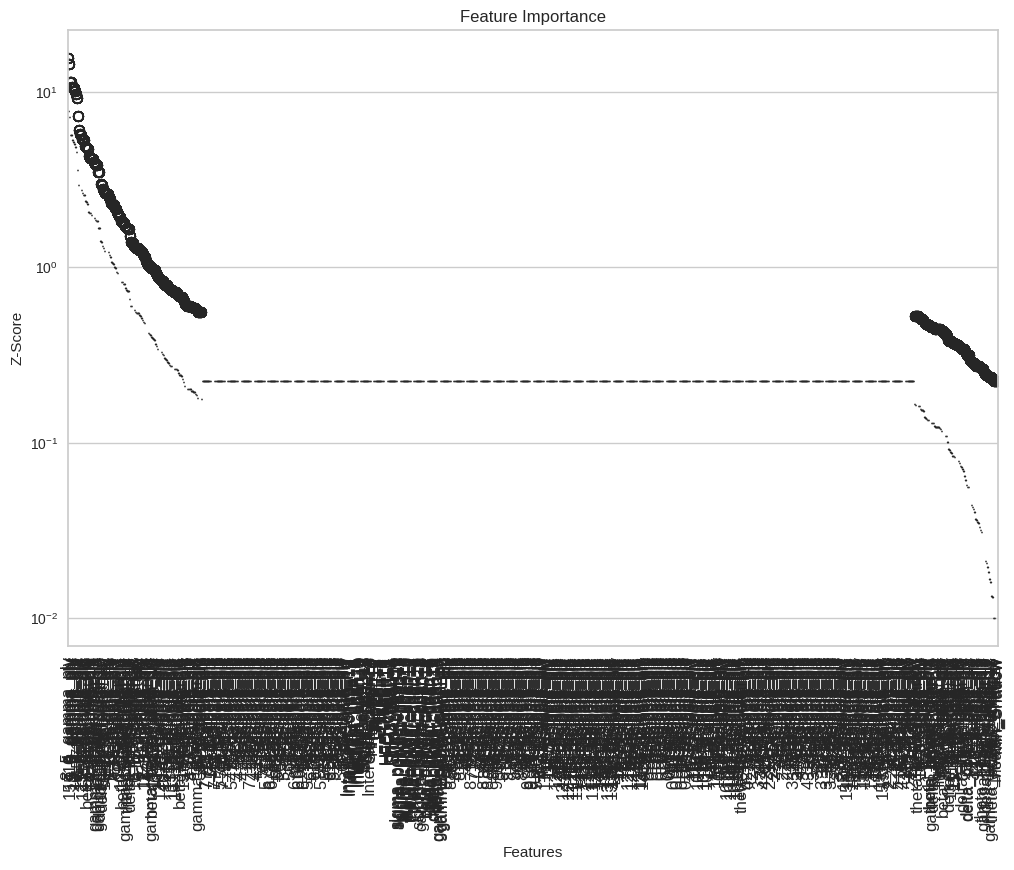

In [79]:
borutashap.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')

In [81]:
subset = borutashap.Subset()

In [88]:
feature_df = pd.DataFrame(data = {'AcceptedFeatures': subset.columns.to_list()})
feature_df.to_csv('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Results/acceptedfeatures.csv')

In [87]:
feature_df['AcceptedFeatures'].to_list()

['13_3_theta_plv',
 '15_5_theta_plv',
 '12_4_sigma_plv',
 '3_2_gamma_plv',
 '10_3_beta_plv',
 '12_11_beta_plv',
 '7_6_gamma_plv',
 '13_2_beta_plv',
 'gamma_power_chan_0',
 '3_2_beta_plv',
 '10_2_gamma_plv',
 '9_0_gamma_plv',
 '4_0_sigma_plv',
 '5_4_gamma_plv',
 '8_6_theta_plv',
 '10_9_sigma_plv',
 '6_5_theta_plv',
 '15_8_gamma_plv',
 '11_9_beta_plv',
 '10_6_beta_plv',
 '9_8_gamma_plv',
 '10_0_gamma_plv',
 'gamma_power_chan_4',
 '7_4_gamma_plv',
 '13_10_beta_plv',
 '9_2_beta_plv',
 'delta_power_chan_9',
 '12_8_theta_plv',
 '10_5_sigma_plv',
 '6_0_beta_plv',
 '4_3_theta_plv',
 '8_7_beta_plv',
 '12_7_gamma_plv',
 '15_5_gamma_plv',
 '12_3_beta_plv',
 'delta_power_chan_13',
 '7_3_beta_plv',
 'delta_power_chan_12',
 '6_5_sigma_plv',
 '11_10_gamma_plv',
 '15_5_sigma_plv',
 '11_8_sigma_plv',
 '15_4_beta_plv',
 'HFD_chan_8',
 'gamma_power_chan_6',
 '7_4_beta_plv',
 '15_8_beta_plv',
 '4_3_gamma_plv',
 '12_2_beta_plv',
 'theta_power_chan_13',
 'DispEn_2',
 '13_3_beta_plv',
 '7_3_gamma_plv',
 '8_4